In [85]:
import pandas as pd
df=pd.read_csv('rest_reviews.csv')


In [86]:
#Data Cleaning code reuse from lab1 

import spacy

nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])
        
def preprocess(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if (token.is_stop ==False and token.lemma_.isalpha()==True)]

In [87]:
#len(df[df['Review'].isnull()])
df_new=df.copy()

In [88]:
del df_new["Recommends"]

In [89]:
df_new.dropna(inplace=True)
df_new.reset_index(inplace=True)

In [90]:
del df_new['index']


In [91]:
df_new.head()

,Review Text,Review
0,The man who is foodie like me for him arabian ...,5.0
1,This place is too much comfortable & food is d...,4.0
2,I check it out like a second home of mine...fe...,3.0
3,"you guys are awesome & I just love your ""offer...",5.0
4,Went there after referred by a friend. Tried t...,5.0


In [92]:
import textblob

# Let's keep only some columns for our final database
df_new.columns = ["Text","Rating"]
df_new.head()

,Text,Rating
0,The man who is foodie like me for him arabian ...,5.0
1,This place is too much comfortable & food is d...,4.0
2,I check it out like a second home of mine...fe...,3.0
3,"you guys are awesome & I just love your ""offer...",5.0
4,Went there after referred by a friend. Tried t...,5.0


In [93]:
df_new.shape

(14678, 2)

In [94]:
# create a column with sentiment polarity
df_new["sentiment_polarity"] = df_new.apply(lambda row: textblob.TextBlob(row["Text"]).sentiment.polarity, axis=1)

# create a column with 'positive' or 'negative' depending on sentiment_polarity
df_new["sentiment"] = df_new.apply(lambda row: "positive" if row["sentiment_polarity"] >= 0 else "negative", axis=1)

# create a column with a text preview after preprocessing
df_new["processed_text"] = df_new["Text"].apply(preprocess)


In [95]:
df_new[:2]
print(df_new[:2].to_latex())

\begin{tabular}{llrrll}
\toprule
{} &                                               Text &  Rating &  sentiment\_polarity & sentiment &                                     processed\_text \\
\midrule
0 &  The man who is foodie like me for him arabian ... &     5.0 &            0.643878 &  positive &  [man, foodie, like, arabian, master, nice, pla... \\
1 &  This place is too much comfortable \& food is d... &     4.0 &            0.582727 &  positive &  [place, comfortable, food, delicious, Item, te... \\
\bottomrule
\end{tabular}



In [96]:
preprocess(df_new['Text'][1])

['place',
 'comfortable',
 'food',
 'delicious',
 'Item',
 'testy',
 'pizza',
 'set',
 'menu',
 'Best',
 'important',
 'Thing',
 'behavior',
 'friendly',
 'good',
 'place',
 'environment',
 'good',
 'behavior',
 'staff',
 'good',
 'price',
 'reasonable',
 'like',
 'service',
 'system',
 'behavior',
 'place']

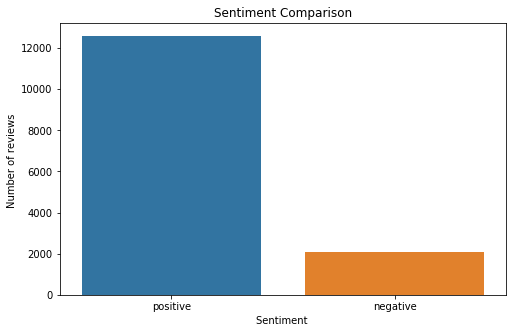

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_count = df_new['sentiment'].value_counts()
df_count
x = np.array(df_count.index)
y = np.array(df_count.values)
plt.figure(figsize=(8,5))
sns.barplot(x,y)
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')
plt.title('Sentiment Comparison')
plt.savefig('Sentiment.eps')


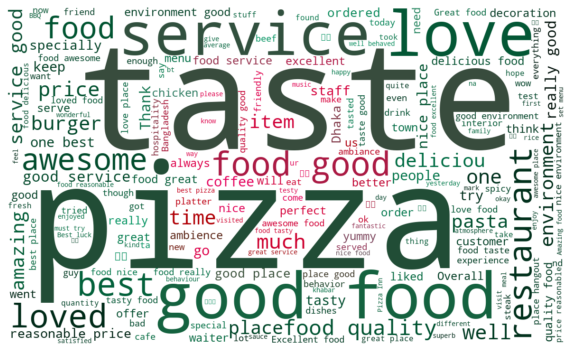

<Figure size 432x288 with 0 Axes>

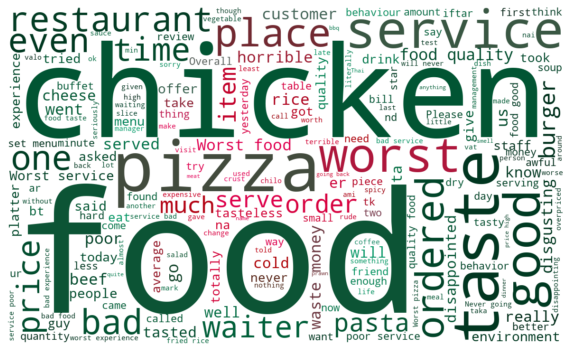

<Figure size 432x288 with 0 Axes>

In [98]:
# Generate a word cloud image
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

mask = np.array(Image.open("bd.png"))
image_colors = ImageColorGenerator(mask)
count=0    
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = "white",
                          mask=mask,height = height).generate(data)
    plt.figure(figsize=[10,15])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.savefig('{:03d}.eps'.format(count))
    plt.show() 



cloud(' '.join(df_new[df_new['sentiment'] == 'positive']['Text']))
plt.savefig('bd_n_pos.eps')
count=count+1
cloud(' '.join(df_new[df_new['sentiment'] == 'negative']['Text']))
plt.savefig('bd_n_neg.eps')


In [99]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( df_new['Text'], df_new['sentiment'], test_size=0.33, random_state=42)

In [100]:
X_train.shape

(9834,)

In [101]:
X_test.shape

(4844,)

In [102]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(analyzer = "word",
                    ngram_range = (1,2),
                    sublinear_tf = True,
                    max_features = 40000, #40000
                    tokenizer = preprocess)
train_tv = tv.fit_transform(X_train)
test_tv = tv.transform(X_test)

#tv = CountVectorizer(analyzer = "word", 
#                            tokenizer = preprocess, 
#                             stop_words = None, 
#                             max_features = 18000,
#                             min_df = 2,
#                             ngram_range = (1,2) #(1, 2) means unigrams and bigrams
#                            ) 

In [103]:
vocab = tv.get_feature_names()
print("Vocabulary length:", len(vocab))

#dist = np.sum(train_tv, axis=0)

#checking = pd.DataFrame(dist,columns = vocab)
print('Training dim:',train_tv.shape, 'Test dim:', test_tv.shape)


Vocabulary length: 40000
Training dim: (9834, 40000) Test dim: (4844, 40000)


In [104]:

y_train_n = y_train.apply(lambda x: 0 if x =='negative' else 1)
y_test_n = y_test.apply(lambda x: 0 if x =='negative' else 1)


In [105]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix


kfold = StratifiedKFold( n_splits = 5 )


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    7.8s finished


Best Score:  0.9563382697058053 

Best Params:  {'C': 0.2, 'class_weight': {1: 4}, 'loss': 'squared_hinge'} 

              precision    recall  f1-score   support

           0       0.94      0.50      0.65       671
           1       0.93      1.00      0.96      4173

    accuracy                           0.93      4844
   macro avg       0.93      0.75      0.81      4844
weighted avg       0.93      0.93      0.92      4844
 

Confusion_matrix:
Accuracy scored:  0.9267134599504542 



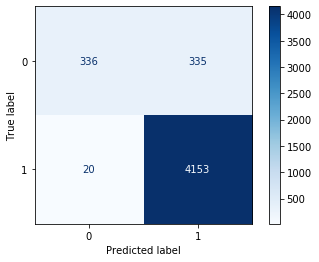

In [106]:

sv = LinearSVC(random_state=42)

gridparams1 = {
    
    'loss':['squared_hinge'],
    'class_weight':[{1:4}],
    'C': [0.2,6,10]
}


gs_sv = GridSearchCV(sv,gridparams1 , verbose = 1, cv = kfold, n_jobs = 3, scoring = 'roc_auc')
gs_sv_fit=gs_sv.fit(train_tv, y_train_n)
gs_sv_best = gs_sv.best_estimator_
submission1 = gs_sv.predict(test_tv) 
print("Best Score: ", gs_sv.best_score_,"\n")
print("Best Params: ", gs_sv.best_params_,"\n")

#print("Classification Report: ")
print(classification_report(y_test_n, submission1, labels=(0,1)),"\n")
print("Confusion_matrix:")
conmax11=(confusion_matrix(y_test_n,submission1))
plot_confusion_matrix(gs_sv_fit, test_tv,y_test_n,display_labels=(0,1),cmap=plt.cm.Blues,normalize=None,values_format='g')
plt.savefig('plot_confusion_matrix11.eps')

accuracy1=accuracy_score(y_test_n, submission1)
print("Accuracy scored: ",accuracy1,"\n")

#Accuracy = TP+TN/TP+FP+FN+TN
Accuracy11=(conmax11[1,1]+conmax11[0,0])/(conmax11[0,0]+conmax11[0,1]+conmax11[1,0]+conmax11[1,1])

#Precision = TP/TP+FP
Precision11=conmax11[1,1]/(conmax11[1,1]+conmax11[0,1])
#Recall = TP/TP+FN
Recall11=conmax11[1,1]/(conmax11[1,1]+conmax11[1,0])
#F1 Score = 2*(Recall * Precision) / (Recall + Precision)
F111=2*(Recall11*Precision11)/(Recall11+Precision11)
#print(Accuracy11,Precision11,Recall11,F111)


In [114]:
Recall11

0.9952072849269111

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.6s finished


Best Score:  0.9094833813130995 

Best Params:  {'alpha': 0.05, 'binarize': 0.001, 'fit_prior': True} 

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       671
           1       0.93      0.96      0.95      4173

    accuracy                           0.91      4844
   macro avg       0.81      0.77      0.79      4844
weighted avg       0.90      0.91      0.90      4844
 

Confusion_matrix:
Accuracy scored:  0.9058629232039637 



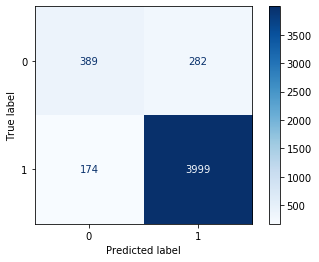

In [107]:
bnb = BernoulliNB()

gridparams2 = {'alpha': [0.001,.05,0.2],
             'binarize': [0.001,0.0],
              'fit_prior': [True, False]}

gs_bnb = GridSearchCV(bnb, gridparams2, verbose = 1, cv = kfold, n_jobs = 1, scoring = "roc_auc")
gs_bnb_fit=gs_bnb.fit(train_tv, y_train_n)
gs_bnb_best = gs_bnb.best_estimator_
submission2 = gs_bnb.predict(test_tv)
print("Best Score: ", gs_bnb.best_score_,"\n")
print("Best Params: ", gs_bnb.best_params_,"\n")

#print("Classification Report: ")
print(classification_report(y_test_n, submission2, labels=(0,1)),"\n")
print("Confusion_matrix:")
#print(confusion_matrix(y_test_n,submission2),"\n") 

plot_confusion_matrix(gs_bnb_fit, test_tv,y_test_n,display_labels=(0,1),cmap=plt.cm.Blues,normalize=None,values_format='g')
plt.savefig('plot_confusion_matrix22.eps')

accuracy2=accuracy_score(y_test_n, submission2)
print("Accuracy scored: ",accuracy2,"\n")

conmax22=(confusion_matrix(y_test_n,submission2))

#Accuracy = TP+TN/TP+FP+FN+TN
Accuracy22=(conmax22[1,1]+conmax22[0,0])/(conmax22[0,0]+conmax22[0,1]+conmax22[1,0]+conmax22[1,1])

#Precision = TP/TP+FP
Precision22=conmax22[1,1]/(conmax22[1,1]+conmax22[0,1])
#Recall = TP/TP+FN
Recall22=conmax22[1,1]/(conmax22[1,1]+conmax22[1,0])
#F1 Score = 2*(Recall * Precision) / (Recall + Precision)
F122=2*(Recall22*Precision22)/(Recall22+Precision22)
#print(Accuracy22,Precision22,Recall22,F122)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.9s finished


Best Score:  0.9226927102783637 

Best Params:  {'alpha': 0.5, 'fit_prior': True} 

              precision    recall  f1-score   support

           0       0.98      0.18      0.31       671
           1       0.88      1.00      0.94      4173

    accuracy                           0.89      4844
   macro avg       0.93      0.59      0.62      4844
weighted avg       0.90      0.89      0.85      4844
 

Confusion_matrix:
Accuracy scored:  0.8864574731626754 



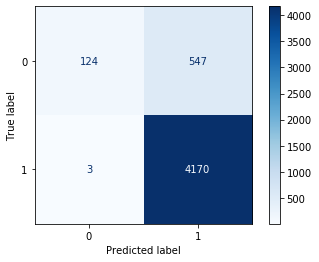

In [108]:
#Naive Bayes 
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from  sklearn.metrics import plot_confusion_matrix

gridparams3 = {
  'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False],
  }


mnb = MultinomialNB()

clf_mnb = GridSearchCV(mnb, gridparams3,cv = kfold, scoring = 'roc_auc', n_jobs = 1, verbose = 1)
clf_mnb_fit=clf_mnb.fit(train_tv, y_train_n)
print("Best Score: ", clf_mnb.best_score_,"\n")
print("Best Params: ", clf_mnb.best_params_,"\n")

clf_mb= clf_mnb.best_estimator_

submission3 = clf_mnb.predict(test_tv)
#print("Classification Report: ")
print(classification_report(y_test_n, submission3, labels=(0,1)),"\n")
print("Confusion_matrix:")
plot_confusion_matrix(clf_mnb_fit, test_tv,y_test_n,display_labels=(0,1),cmap=plt.cm.Blues,normalize=None,values_format='g')
plt.savefig('plot_confusion_matrix33.eps')


accuracy3=accuracy_score(y_test_n, submission3)
print("Accuracy scored: ",accuracy3,"\n")

conmax33=(confusion_matrix(y_test_n,submission3))

#Accuracy = TP+TN/TP+FP+FN+TN
Accuracy33=(conmax33[1,1]+conmax33[0,0])/(conmax33[0,0]+conmax33[0,1]+conmax33[1,0]+conmax33[1,1])

#Precision = TP/TP+FP
Precision33=conmax33[1,1]/(conmax33[1,1]+conmax33[0,1])
#Recall = TP/TP+FN
Recall33=conmax33[1,1]/(conmax33[1,1]+conmax33[1,0])
#F1 Score = 2*(Recall * Precision) / (Recall + Precision)
F133=2*(Recall33*Precision33)/(Recall33+Precision33)
#print(Accuracy33,Precision33,Recall33,F133)



Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.2s finished


Best Score:  0.9584990311597 

Best Params:  {'C': 10, 'class_weight': {1: 1}, 'dual': True, 'penalty': 'l2', 'solver': 'liblinear'} 

              precision    recall  f1-score   support

           0       0.84      0.70      0.76       671
           1       0.95      0.98      0.97      4173

    accuracy                           0.94      4844
   macro avg       0.90      0.84      0.87      4844
weighted avg       0.94      0.94      0.94      4844
 

Confusion_matrix:
Accuracy scored:  0.9403385631709331 



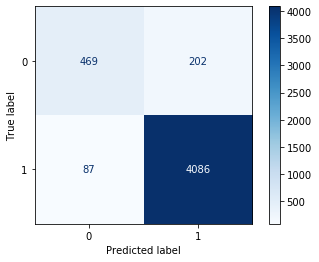

In [109]:
from sklearn.pipeline import Pipeline
lr = LogisticRegression(random_state = 12345)
gridparams4 = {
    'penalty':['l2'],
    'dual':[True,False],
    'C':[0.2,10],
    'solver' : ['liblinear'],
    'class_weight':[{1:1},{1:2}]
    }

lr_CV = GridSearchCV(lr, gridparams4, cv = kfold, scoring = 'roc_auc', n_jobs = 1, verbose = 1)
lr_CV_fit=lr_CV.fit(train_tv, y_train_n)
logi_best = lr_CV.best_estimator_
submission4 = lr_CV.predict(test_tv)
print("Best Score: ", lr_CV.best_score_,"\n")
print("Best Params: ", lr_CV.best_params_,"\n")
#print("Classification Report: ")
print(classification_report(y_test_n, submission4, labels=(0,1)),"\n")

print("Confusion_matrix:")
plot_confusion_matrix(lr_CV_fit, test_tv,y_test_n,display_labels=(0,1),cmap=plt.cm.Blues,normalize=None,values_format='g')
plt.savefig('plot_confusion_matrix44.eps',
           dpi=300)

accuracy4=accuracy_score(y_test_n, submission4)
print("Accuracy scored: ",accuracy4,"\n")

#print(lr_CV.cv_results_)

conmax44=(confusion_matrix(y_test_n,submission4))

#Accuracy = TP+TN/TP+FP+FN+TN
Accuracy44=(conmax44[1,1]+conmax44[0,0])/(conmax44[0,0]+conmax44[0,1]+conmax44[1,0]+conmax44[1,1])

#Precision = TP/TP+FP
Precision44=conmax44[1,1]/(conmax44[1,1]+conmax44[0,1])
#Recall = TP/TP+FN
Recall44=conmax44[1,1]/(conmax44[1,1]+conmax44[1,0])
#F1 Score = 2*(Recall * Precision) / (Recall + Precision)
F144=2*(Recall44*Precision44)/(Recall44+Precision44)
#print(Accuracy44,Precision44,Recall44,F144)
#https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
    

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data={'Classification Tech':['Linear SVC','Bernoulli NB','Multinomial NB','Logistic Regression'],
      'Best Score from CV': [gs_sv.best_score_,gs_bnb.best_score_,clf_mnb.best_score_,lr_CV.best_score_],
      'Accuracy': [accuracy1,accuracy2,accuracy3,accuracy4],
      'Precision': [Precision11,Precision22,Precision33,Precision44],
      'Recall': [Recall11,Recall22,Recall33,Recall44],
      'F1-score': [F111,F122,F133,F144]}
      
comparedf=round(pd.DataFrame(data),2)
comparedf
#print(comparedf.to_latex(comparedf.tex))


,Classification Tech,Best Score from CV,Accuracy,Precision,Recall,F1-score
0,Linear SVC,0.96,0.93,0.93,1.00,0.96
1,Bernoulli NB,0.91,0.91,0.93,0.96,0.95
2,Multinomial NB,0.92,0.89,0.88,1.00,0.94
3,Logistic Regression,0.96,0.94,0.95,0.98,0.97


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


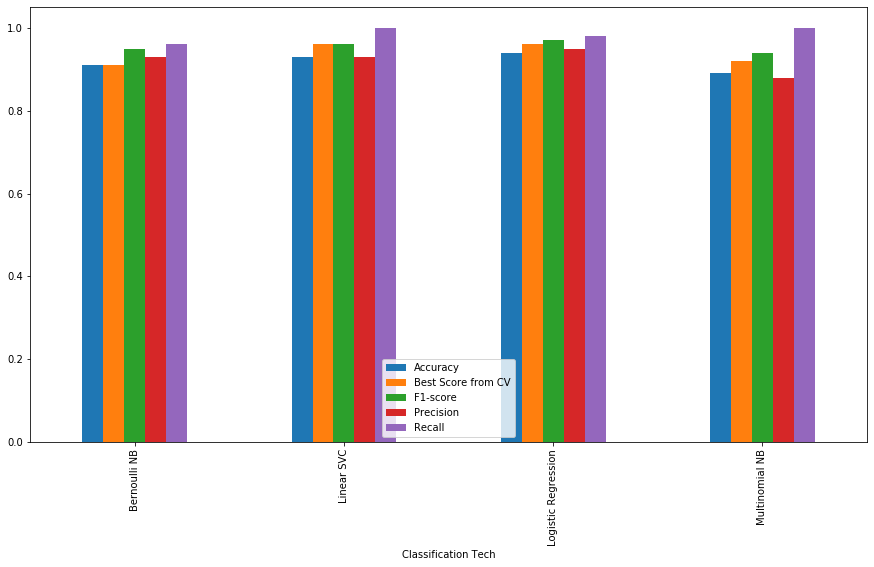

In [112]:
table = pd.pivot_table(data=comparedf,index='Classification Tech')
table
table.plot(kind='bar',figsize=(15,8))
plt.savefig('Classifier_Measurement.eps')